In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 都市マスクカバー率

In [7]:
# やることリスト
# dwntownアルゴリズムが発動している都市を調べる
# どの都市のcover rateがおかしいか調べる(ロサンゼルスやサンパウロを修正する) > wupの重複があるときのみclusteringを作動させる?
# overlapの都市で修正できるものは修正する(香港など)
# 再度都市マスクをmanual_revise版として作成する
# 新しい都市マスクでprfとswgを推定する(prfだけでよい？)
# MERIT-Hydro内だけから取水可能なsubbasinを推定する(最大遠隔距離は100kmとする?)

In [30]:
file_path = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/cty_lst_/camacity_first.txt'
data = []
with open(file_path, 'r') as file:
    for line in file:
        row = line.strip().split('|')
        data.append(row)

index_list = [int(i[0]) for i in data if i[1] != 'NoMASK']
dwnflg_list = [i[2] for i in data if i[1] != 'NoMASK']
wuppop_list = [float(i[3])/1e3 for i in data if i[1] != 'NoMASK']
fulpop_list = [float(i[4])/1e6 for i in data if i[1] != 'NoMASK']
vldpop_list = [float(i[5])/1e6 for i in data if i[1] != 'NoMASK']
name_list = [i[10] for i in data if i[1] != 'NoMASK']

coverage_list = [v/w for v, w in zip(vldpop_list, wuppop_list)]

len of wuppop: 1553
len of dwn_wuppop: 178
len of ful_wuppop: 1375
NRMSE: 0.05401595443480942
PBIAS: -29.80711988601519
R²: 0.8244535670336944
NSE: 0.8244535670336944
KGE: 0.6076460205348139
NRMSE: 0.0057880601352562665
PBIAS: 2.698405118221149
R²: 0.9939427414522924
NSE: 0.9939427414522924
KGE: 0.9725972962893285


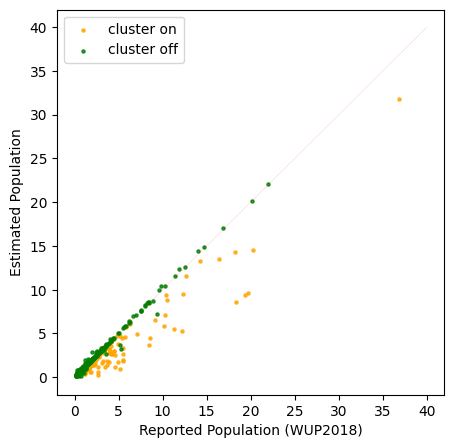

In [91]:
print(f'len of wuppop: {len(wuppop_list)}')
dwn_wuppop = [float(i[3])/1e3 for i in data if i[1] != 'NoMASK' and i[2] == 'True']
dwn_vldpop = [float(i[5])/1e6 for i in data if i[1] != 'NoMASK' and i[2] == 'True']
ful_wuppop = [float(i[3])/1e3 for i in data if i[1] != 'NoMASK' and i[2] == 'False']
ful_vldpop = [float(i[5])/1e6 for i in data if i[1] != 'NoMASK' and i[2] == 'False']
print(f'len of dwn_wuppop: {len(dwn_wuppop)}')
print(f'len of ful_wuppop: {len(ful_wuppop)}')

dwn_wup_arr = np.array(dwn_wuppop)
dwn_vld_arr = np.array(dwn_vldpop)
ful_wup_arr = np.array(ful_wuppop)
ful_vld_arr = np.array(ful_vldpop)

fig, ax = plt.subplots(figsize=(5, 5))

# Add a y=x line
ax.plot(x, x, color='red', linestyle='--', linewidth=0.1)
x = np.linspace(0, 40, 100)

# scatter
ax.scatter(dwn_wup_arr, dwn_vld_arr, s=5, color='Orange', alpha=0.8, label='cluster on')
ax.scatter(ful_wup_arr, ful_vld_arr, s=5, color='Green', alpha=0.8, label='cluster off')

# adjust
#ax.set_xlim(0, 25)
#ax.set_ylim(0, 25)
ax.set_xlabel('Reported Population (WUP2018)')
ax.set_ylabel('Estimated Population')
plt.legend()

import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

def static(stt, est):
    # 1. NRMSE (正規化された平均平方根誤差)
    rmse = np.sqrt(mean_squared_error(stt, est))
    nrmse = rmse / (stt.max() - stt.min())
    
    # 2. PBIAS (パーセントバイアス)
    pbias = 100 * np.sum(est - stt) / np.sum(stt)
    
    # 3. R² (決定係数)
    r2 = r2_score(stt, est)
    
    # 4. NSE (ナッシュ-サトクリフ効率)
    nse = 1 - (np.sum((stt - est) ** 2) / np.sum((stt - np.mean(stt)) ** 2))
    
    # 5. KGE (クリング-グプタ効率)
    cc = np.corrcoef(stt, est)[0, 1]  # 相関係数
    alpha = np.std(est) / np.std(stt)  # 標準偏差の比率
    beta = np.mean(est) / np.mean(stt) # 平均の比率
    kge = 1 - np.sqrt((cc - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    
    # 結果を表示
    print(f'NRMSE: {nrmse}')
    print(f'PBIAS: {pbias}')
    print(f'R²: {r2}')
    print(f'NSE: {nse}')
    print(f'KGE: {kge}')

static(dwn_wup_arr, dwn_vld_arr)
static(ful_wup_arr, ful_vld_arr)


429 881 1549


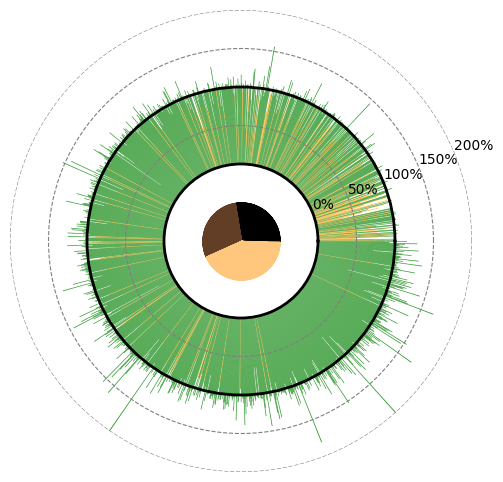

In [85]:
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'polar': True})

length = len(wuppop_list)
rate = [v/w for v, w in zip(vldpop_list, wuppop_list)]

colors = ['orange' if d == 'True' else 'green' for d in dwnflg_list]
angles = np.linspace(0, 2 * np.pi,  length, endpoint=False)
bars = ax.bar(angles, rate, width=2 * np.pi / length, 
              bottom=1, color=colors, alpha=0.8)

# Define the angles and radii
def label(ax, arg_start, arg_end, color='blue'):
    fill_num = 0.5
    piece = 100
    theta = np.linspace(arg_start*2*np.pi/length, arg_end*2*np.pi/length, piece)
    r = np.linspace(0, fill_num, piece)
    r, theta = np.meshgrid(r, theta)
    ax.fill_between(theta.flatten(), fill_num, r.flatten(), color=color)

arg_0 = 0
arg_1 = np.argmax(np.array(wuppop_list) < 1.0)
label(ax, arg_0, arg_1, color='k')
arg_2 = np.argmax(np.array(wuppop_list) < 0.5)
label(ax, arg_1, arg_2, color='#623e27')
arg_3 = np.argmax(np.array(wuppop_list) < 0.2)
label(ax, arg_2, arg_3, color='#ffc67e')
print(arg_1, arg_2, arg_3)

# ticks
ax.set_xticks([])  # X軸の目盛りを非表示
#ax.set_yticks([])  # Y軸の目盛りを非表示
yticks = [1, 1.5, 2.0, 2.5, 3.0]  # 目盛りの位置
yticks_labels = ['0%', '50%', '100%', '150%', '200%']  # 表示ラベル
ax.set_yticks(yticks)
ax.set_yticklabels(yticks_labels)
ax.set_ylim(0, 3.0)  # 0から200%の範囲
ax.yaxis.grid(True)  # グリッドを有効にする
gridlines = ax.get_ygridlines()  # y軸のグリッドラインを取得
for i, line in enumerate(gridlines):
    if yticks[i] == 2.0:  # 100%の部分
        line.set_linestyle('-')  # 実線
        line.set_color('black')  # 黒色に設定
        line.set_linewidth(2.0)  # 線の太さを太く設定
    elif yticks[i] == 1.0:  # 100%の部分
        line.set_linestyle('-')  # 実線
        line.set_color('black')  # 黒色に設定
        line.set_linewidth(2.0)  # 線の太さを太く設定
    else:
        line.set_linestyle('--')  # 破線
        line.set_color('gray')  # 他の線は灰色に設定

# 外枠の黒線を見えなくする
ax.spines['polar'].set_visible(False)  # 外枠を非表示

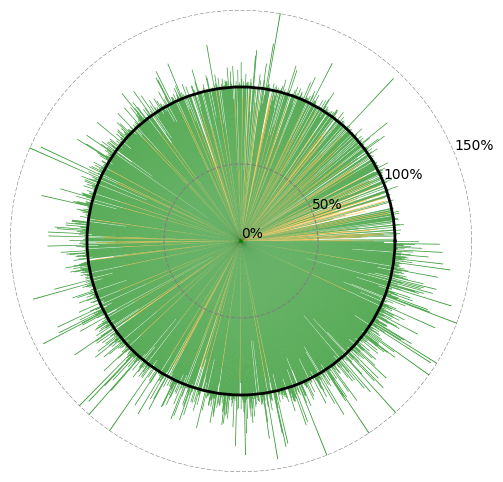

In [89]:
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'polar': True})

length = len(wuppop_list)
rate = [v/w for v, w in zip(vldpop_list, wuppop_list)]

colors = ['orange' if d == 'True' else 'green' for d in dwnflg_list]
angles = np.linspace(0, 2 * np.pi,  length, endpoint=False)
bars = ax.bar(angles, rate, width=2 * np.pi / length, 
              bottom=0, color=colors, alpha=0.8)

# Define the angles and radii
def label(ax, arg_start, arg_end, color='blue'):
    fill_num = 0.5
    piece = 100
    theta = np.linspace(arg_start*2*np.pi/length, arg_end*2*np.pi/length, piece)
    r = np.linspace(0, fill_num, piece)
    r, theta = np.meshgrid(r, theta)
    ax.fill_between(theta.flatten(), fill_num, r.flatten(), color=color)

#arg_0 = 0
#arg_1 = np.argmax(np.array(wuppop_list) < 1.0)
#label(ax, arg_0, arg_1, color='k')
#arg_2 = np.argmax(np.array(wuppop_list) < 0.5)
#label(ax, arg_1, arg_2, color='#623e27')
#arg_3 = np.argmax(np.array(wuppop_list) < 0.2)
#label(ax, arg_2, arg_3, color='#ffc67e')

# ticks
ax.set_xticks([])  # X軸の目盛りを非表示
#ax.set_yticks([])  # Y軸の目盛りを非表示
yticks = [0, 0.5, 1.0, 1.5, 2.0]  # 目盛りの位置
yticks_labels = ['0%', '50%', '100%', '150%', '200%']  # 表示ラベル
ax.set_yticks(yticks)
ax.set_yticklabels(yticks_labels)
ax.set_ylim(0, 1.5)  # 0から200%の範囲
ax.yaxis.grid(True)  # グリッドを有効にする
gridlines = ax.get_ygridlines()  # y軸のグリッドラインを取得
for i, line in enumerate(gridlines):
    if yticks[i] == 0.0:  # 100%の部分
        line.set_linestyle('-')  # 実線
        line.set_color('black')  # 黒色に設定
        line.set_linewidth(2.0)  # 線の太さを太く設定
    elif yticks[i] == 1.0:  # 100%の部分
        line.set_linestyle('-')  # 実線
        line.set_color('black')  # 黒色に設定
        line.set_linewidth(2.0)  # 線の太さを太く設定
    else:
        line.set_linestyle('--')  # 破線
        line.set_color('gray')  # 他の線は灰色に設定

# 外枠の黒線を見えなくする
ax.spines['polar'].set_visible(False)  # 外枠を非表示

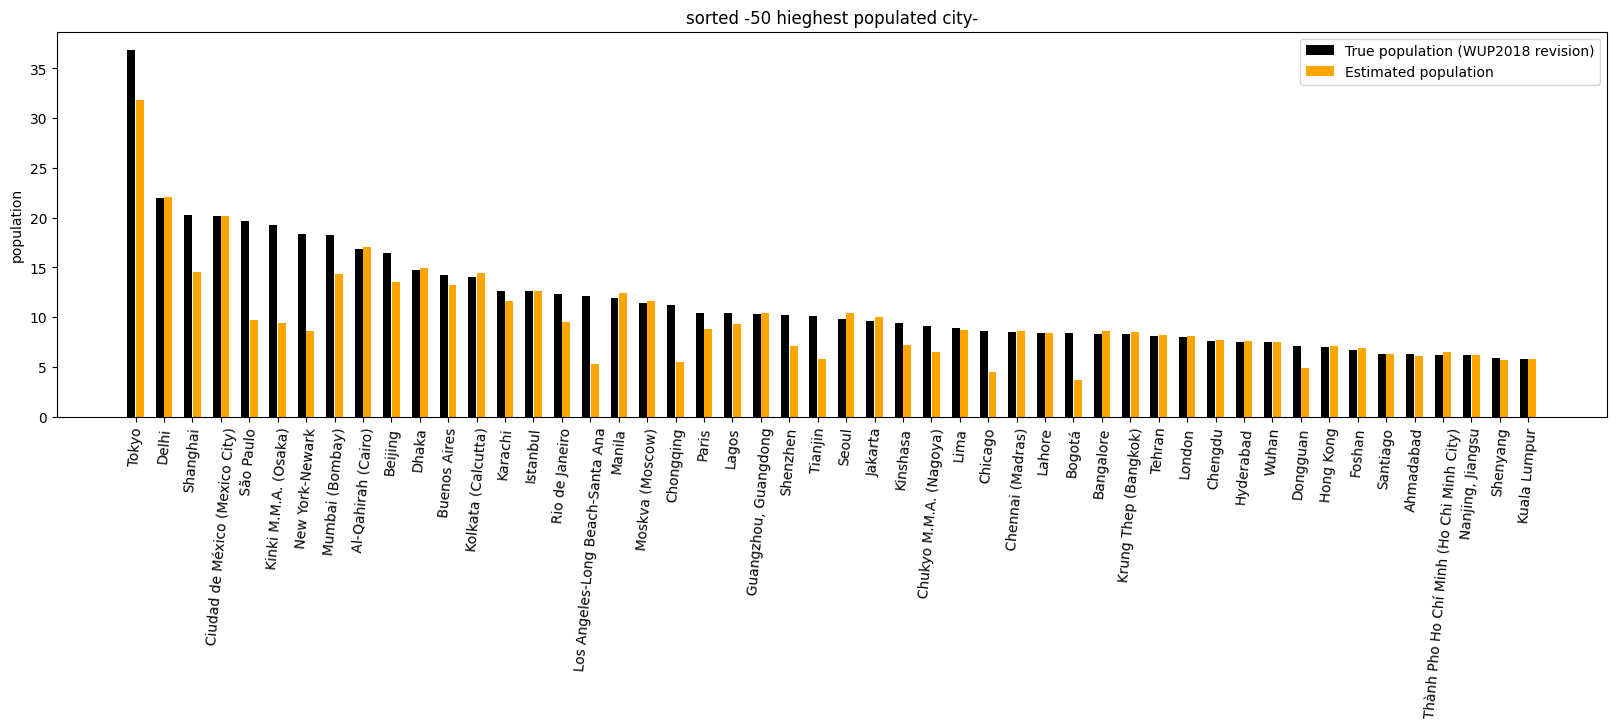

In [51]:
start = 0
end = 50

fig, ax = plt.subplots(figsize=(20, 5))
x = np.arange(end)
gap = 0.15
width=0.28
ax.bar(x-gap, wuppop_list[start:end], width, label='True population (WUP2018 revision)', color='black')
ax.bar(x+gap, vldpop_list[start:end], width, label='Estimated population', color='orange')
ax.set_xticks(x)
ax.set_xticklabels(name_list[start:end], fontsize=10, rotation=85)
ax.set_ylabel('population')
ax.set_title('sorted -50 hieghest populated city-')
ax.legend()